# Submission using XGBoost

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline

## Prepare data

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
df = pd.read_pickle('input/train.p')

In [4]:
training_fields = ['tf_similarity', 'tf_similarity2', 'diff_avg_word']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
        df[training_fields], df['is_duplicate'], test_size=0.2, random_state=42)

## Training XGBoost model

In [6]:
import xgboost as xgb

In [7]:
# Set our parameters for xgboost
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 5

In [8]:
d_train = xgb.DMatrix(X_train[training_fields], label=y_train)
d_valid = xgb.DMatrix(X_test[training_fields], label=y_test)
watchlist = [(d_train, 'train'), (d_valid, 'valid')]
bst = xgb.train(params, d_train, 200, watchlist, early_stopping_rounds=50, verbose_eval=10)

[0]	train-logloss:0.688112	valid-logloss:0.688155
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[10]	train-logloss:0.646923	valid-logloss:0.647375
[20]	train-logloss:0.617731	valid-logloss:0.618564
[30]	train-logloss:0.596269	valid-logloss:0.597436
[40]	train-logloss:0.58033	valid-logloss:0.58179
[50]	train-logloss:0.568273	valid-logloss:0.569996
[60]	train-logloss:0.559022	valid-logloss:0.561021
[70]	train-logloss:0.551857	valid-logloss:0.554097
[80]	train-logloss:0.546292	valid-logloss:0.548774
[90]	train-logloss:0.541842	valid-logloss:0.544535
[100]	train-logloss:0.538377	valid-logloss:0.541261
[110]	train-logloss:0.535594	valid-logloss:0.538631
[120]	train-logloss:0.533386	valid-logloss:0.536563
[130]	train-logloss:0.531626	valid-logloss:0.53494
[140]	train-logloss:0.530225	valid-logloss:0.533665
[150]	train-logloss:0.529082	valid-logloss:0.532643
[160]	train-logloss:0.528119	va

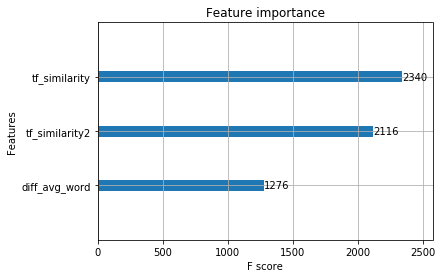

In [9]:
bst.save_model('input/bst_52.model')
xgb.plot_importance(bst)

## Submission

In [22]:
from utils import make_features
from utils import parallelize_dataframe
from utils import preprocessing
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances
from sklearn.feature_extraction.text import TfidfVectorizer

In [14]:
df_test = pd.read_csv('input/test.csv')
df_test.head()

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


In [24]:
print("Make TfidfVector2...")
vectorizer = TfidfVectorizer(lowercase=False, ngram_range=(1,2))
vectorizer.fit(df_test['question1'].append(df_test['question2']))

df_test['q1_vect2'] = list(vectorizer.transform(df_test['question1']))
df_test['q2_vect2'] = list(vectorizer.transform(df_test['question2']))

print("Make TfidfVector1...")
vectorizer = TfidfVectorizer(lowercase=False, ngram_range=(1,2), max_features=10000, max_df=0.5, min_df=2, use_idf=True)
vectorizer.fit(df_test['question1'].append(df_test['question2']))

print("Transform to vector...")
df_test['q1_vect'] = list(vectorizer.transform(df_test['question1']))
df_test['q2_vect'] = list(vectorizer.transform(df_test['question2']))

Make TfidfVector2...
Make TfidfVector1...
Transform to vector...


In [ ]:
df_test.to_pickle('input/test.p')

In [26]:
print("Make cosine similarity...")
df_test['tf_similarity'] = df_test.apply(cosine_similarity(df_test['q1_vect'], df_test['q2_vect'])[0], axis=1)['id']
# df_test['tf_similarity2'] = df_test.apply(cosine_similarity(df_test['q1_vect2'], df_test['q2_vect2'])[0], axis=1)['id']

Make cosine similarity...


ValueError: setting an array element with a sequence.

In [20]:
d_test = xgb.DMatrix(x_test)
p_test = bst.predict(d_test)

In [ ]:
sub = pd.DataFrame()
sub['test_id'] = df_test['test_id']
sub['is_duplicate'] = p_test
sub.to_csv('simple_xgb.csv', index=False)

## Result

- TF-IDF1 similarity : 0.55
- TF-IDF2 similarity : 0.58
- Word length : 0.63
- Both features : 0.52